# 04 — SHAP Explainability

Goal:
- Load trained model pipeline
- Compute SHAP values
- Create global summary plot
- Create one local explanation


In [ ]:
import os, joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

DATA_OBJ = "../artifacts/data/splits_and_preprocess.joblib"
X_train, X_test, y_train, y_test, preprocess = joblib.load(DATA_OBJ)

MODEL_PATH = "../artifacts/models/churn_model_rf.joblib"
if not os.path.exists(MODEL_PATH):
    MODEL_PATH = "../artifacts/models/churn_model_logreg.joblib"

assert os.path.exists(MODEL_PATH), "Run notebook 03 first to save a model."
model = joblib.load(MODEL_PATH)
model


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'Churn'])])),
                ('model', LogisticRegression(max_iter=2000))])

In [3]:
# Get feature names after preprocessing
pre = model.named_steps["preprocess"]

num_cols = pre.transformers_[0][2]
cat_cols = pre.transformers_[1][2]

ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

feature_names = list(num_cols) + cat_feature_names
len(feature_names)


46

In [ ]:
X_test_trans = pre.transform(X_test)
X_train_trans = pre.transform(X_train)


try:
    X_test_dense = X_test_trans.toarray()
    X_train_dense = X_train_trans.toarray()
except:
    X_test_dense = np.array(X_test_trans)
    X_train_dense = np.array(X_train_trans)

X_test_dense.shape


(1409, 46)

In [ ]:
clf = model.named_steps["model"]


if hasattr(clf, "predict_proba"):
    pred_fn = clf.predict_proba
else:
    pred_fn = clf.predict

is_tree = clf.__class__.__name__.lower().find("forest") >= 0 or clf.__class__.__name__.lower().find("xgb") >= 0

if is_tree:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test_dense)
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
else:
    background = shap.sample(X_train_dense, 200, random_state=42)
    explainer = shap.KernelExplainer(pred_fn, background)
    sv = explainer.shap_values(shap.sample(X_test_dense, 200, random_state=42))
    sv = sv[1] if isinstance(sv, list) else sv

type(sv), np.array(sv).shape


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:48<00:00,  4.14it/s]


(numpy.ndarray, (200, 46, 2))

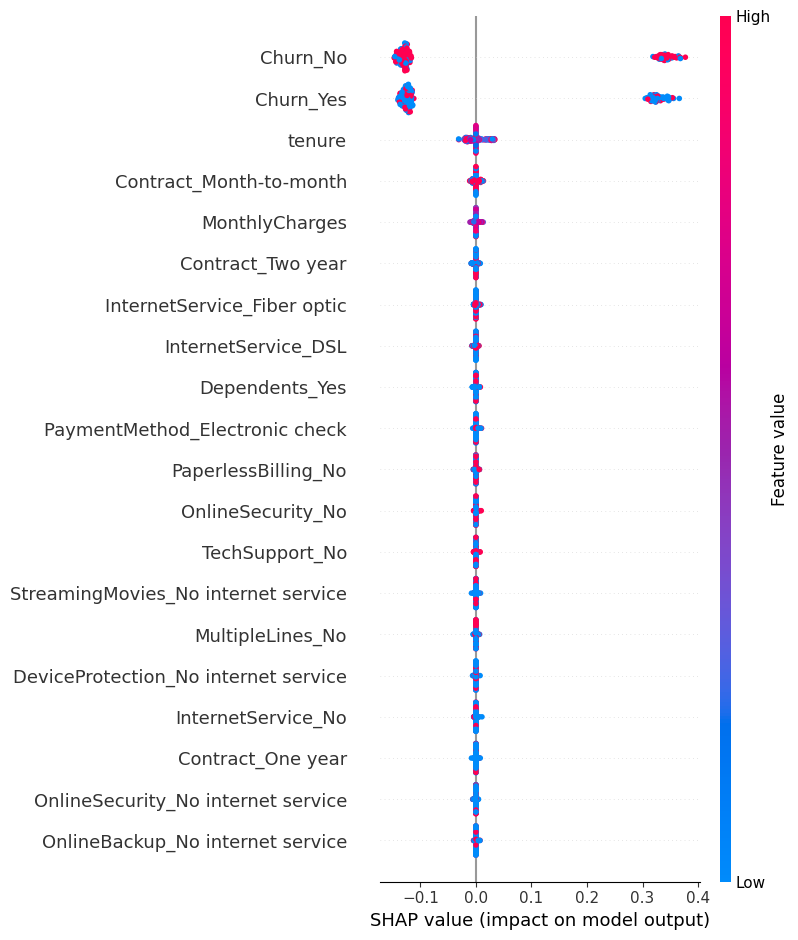

Saved: ../artifacts/figures/shap_summary.png


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import shap

os.makedirs("../artifacts/figures", exist_ok=True)

n = min(200, sv.shape[0]) 
rng = np.random.default_rng(42)
idx = rng.choice(sv.shape[0], size=n, replace=False)
X_explain_dense = X_test_dense[:sv.shape[0], :] 

X_sample = X_explain_dense[idx]
sv_sample = sv[idx, :, 1]  

plt.figure()
shap.summary_plot(sv_sample, X_sample, feature_names=feature_names, show=False)
plt.savefig("../artifacts/figures/shap_summary.png", bbox_inches="tight", dpi=200)
plt.show()

print("Saved: ../artifacts/figures/shap_summary.png")
